[ 1.00000000e+00  1.01325000e+05  2.50000000e+03  3.00000000e-01
  7.00000000e-01  1.00000000e+00 -2.20583626e+05 -1.94101859e+05
 -1.11878832e+02  2.14055264e+05]


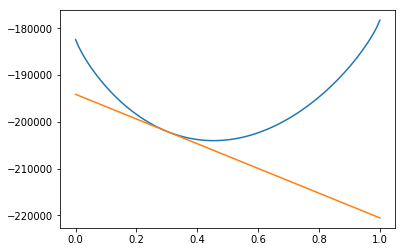

In [1]:
import numpy as np
from autograd import grad
from pycalphad import Database, Model, variables as v
from pycalphad.tests.datasets import ALFE_TDB
from pycalphad.codegen.sympydiff_utils import build_functions

dbf = Database(ALFE_TDB)
mod = Model(dbf, ['AL', 'FE'], 'LIQUID')
state_variables = [v.N, v.P, v.T]
site_fracs = mod.site_fractions
build_output = build_functions(mod.GM, tuple(state_variables + site_fracs),
                               include_grad=True, include_hess=False)
cf, gf, hf = build_output.func, build_output.grad, build_output.hess

def toy_objective(x):
    # N,P,T,y1,y2,np,mu_a,mu_b,tau_1,tau_2
    inp = np.ascontiguousarray(x[:, :5])
    obj = cf(*x[:, :5])
    lagrange = x[:, 6]*(0.3 - x[:, 5]*x[:, 3]) + x[:, 7]*(0.7 - x[:, 5]*x[:, 4]) + \
               x[:, 8]*(2500 - x[:, 2]) + x[:, 9]*(1 - (x[:, 3]+x[:, 4]))
    return x[:,5] * obj + lagrange

def toy_gradient(x):
    grad = gf(*x[:5])
    obj = cf(*x[:5])
    out = np.zeros(x.shape[0])
    out[:5] = [x[5]*g for g in grad]
    out[5] = obj
    out[6] = 0.3 - x[5]*x[3]
    out[5] += -x[6]*x[3]
    out[3] += -x[6]*x[5]
    
    out[7] = 0.7 - x[5]*x[4]
    out[5] += -x[7]*x[4]
    out[4] += -x[7]*x[5]
    
    out[8] = 2500 - x[2]
    out[2] += -x[8]

    out[9] = 1 - (x[3]+x[4])
    out[3] += -x[9]
    out[4] += -x[9]
    return out

from scipy.optimize import fsolve

delta = 1e-3
result = fsolve(toy_gradient, [1.00000000e+00, 1.01325000e+05, 2.50000000e+03, 7.01402806e-01,
       2.98597194e-01, 3.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0, 0])
print(result)

%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace([1,1e5, 2500, 1e-4, 1-1e-4, 1, 0, 0, 0, 0], [1, 1e5, 2500, 1-1e-4, 1e-4, 1, 0, 0, 0,0], 100)
y = toy_objective(x)
plt.plot(x[:, 3], y)
plt.plot([0, 1], [result[7], result[6]])
plt.show()

In [39]:
from pycalphad.core.problem import Problem
from pycalphad.core.composition_set import CompositionSet
from pycalphad.codegen.callables import build_phase_records

conds = {v.N: 1, v.P: 1e5, v.T: 2500, v.X('FE'): 0.7}
comps = [v.Species('AL'), v.Species('FE')]

prx = build_phase_records(dbf, comps, ['LIQUID'], conds,
                         models={'LIQUID': mod}, build_gradients=True)
prx = prx['LIQUID']
compset = CompositionSet(prx)
prob = Problem([compset], comps, {str(key): value for key, value in conds.items()}, [0, 0])

def pycalphad_obj(x):
    obj = prob.objective(x[:8])
    c = prob.cl[2:] - prob.constraints(x[:8])[2:]
    lagrange = np.sum(-c * x[8:])
    return obj+lagrange

def pycalphad_grad(x):
    out = np.zeros(x.shape[0])
    res = prob.gradient(x[:8])
    c = prob.cl[2:] - prob.constraints(x[:8])[2:]
    out[:8] = res
    out[:8] += -np.dot(prob.jacobian(x[:8])[2:].T, x[8:])
    out[8:] = -c
    return out

('fixed_total_moles', array([0.3, 0.7]))


In [40]:
x = [1.00000000e+00, 1.01325000e+05, 2.50000000e+03, 7.01402806e-01,
       2.98597194e-01, 3.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0, 0]
pycalphad_grad(np.array(x))

array([ 0.00000000e+00,  0.00000000e+00, -3.18868759e+01,  7.70156224e+03,
       -3.80257214e+03, -1.99247053e+05,  8.95791582e-02,  6.10420842e-01,
       -0.00000000e+00,  5.55111512e-17])

In [41]:
toy_gradient(np.array(x))

array([ 0.00000000e+00,  0.00000000e+00, -3.18868759e+01,  7.70156224e+03,
       -3.80257214e+03, -1.99247053e+05,  8.95791582e-02,  6.10420842e-01,
        0.00000000e+00,  0.00000000e+00])

[ 1.00000000e+00  1.01325000e+05  2.50000000e+03  3.00000000e-01
  7.00000000e-01  1.00000000e+00 -2.20583626e+05 -1.94101859e+05
 -1.11878832e+02  2.14055264e+05]


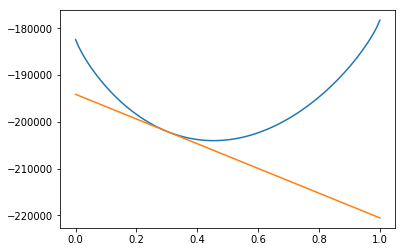

In [42]:
from scipy.optimize import fsolve

delta = 1e-3
result = fsolve(pycalphad_grad, [1.00000000e+00, 1.01325000e+05, 2.50000000e+03, 7.01402806e-01,
       2.98597194e-01, 3.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0, 0])
print(result)

%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace([1,1e5, 2500, 1e-4, 1-1e-4, 1, 0, 0, 0, 0], [1, 1e5, 2500, 1-1e-4, 1e-4, 1, 0, 0, 0,0], 100)
y = [pycalphad_obj(z) for z in x]
plt.plot(x[:, 3], y)
plt.plot([0, 1], [result[7], result[6]])
plt.show()

In [43]:
pycalphad_grad(np.array(result))

array([ 0.00000000e+00,  0.00000000e+00,  8.52651283e-14,  2.38651410e-09,
        2.85217538e-09, -5.50062396e-09,  1.16573418e-15, -1.11022302e-15,
       -0.00000000e+00, -0.00000000e+00])

In [44]:
toy_gradient(np.array(result))

array([ 0.00000000e+00,  0.00000000e+00,  8.52651283e-14,  2.38651410e-09,
        2.85217538e-09, -5.50062396e-09,  1.11022302e-15, -1.11022302e-15,
        0.00000000e+00,  0.00000000e+00])